## wf-opto class dev / 7/17 data

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import scipy

import pytoolsAL as ptAL

class wfOpto:
    '''
    contains some functions for common operations with wf-opto data
    '''
    def __init__(self, pathSubject):
        serverPath = Path(pathSubject)
        self.timeFile = serverPath / 'cameraFrameTimes.npy'
        self.frameTimes = np.squeeze(np.load(self.timeFile))[::2] # every other frame - we want blue only
        self.svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
        self.svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
        self.meanImage = np.load(serverPath / 'blue/meanImage.npy')
        self.laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
        self.laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
        self.svdSpatFull = self.svdSpat[:,:,:500]
        self.laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
        galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
        galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
        self.px, self.py, self.ncomps = self.svdSpatFull.shape
        self.svdSpat = self.svdSpatFull.reshape(self.px*self.py, self.ncomps)
        self.tToWf = scipy.interpolate.interp1d(self.frameTimes, self.svdTemp, axis=0, fill_value='extrapolate')
        self.pulseLengths = []
        for count,time in enumerate(self.laserOff):
            length = self.laserOff[count]-self.laserOn[count]
            self.pulseLengths.append(length)
        self.pulseLengths = np.array(self.pulseLengths)
    def oneTrial(self, start, stop, step, trial):
        '''
        creates video for a single trial
        '''
        startTime = self.laserOn[trial] + start
        endTime = self.laserOn[trial] + stop
        
        trial_time = np.linspace(startTime, endTime, step)
        trial_activity = self.tToWf(trial_time)
        
        dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
        dwf = np.array(dwf)
        
        spatial = self.svdSpatFull.reshape(560*560, -1)
        video = spatial @ dwf
        video = video.reshape(560, 560, -1)
        
        n_cols = 5
        n_rows = 10
        f = plt.figure(figsize=(n_cols*2, n_rows*2))
        gs = mpl.gridspec.GridSpec(n_rows, n_cols)
        for i in range(50):
            ax = plt.subplot(gs[i])
            plt.imshow(video[:, :, i*2],clim = np.percentile(video, (2, 99.9)), cmap='bwr')
            plt.title(f't = {trial_time[i*2]:.2f}s')
            plt.colorbar()
            
        f.tight_layout()
    def allTrials(self, start, stop, step):
        '''
        creates videos for all trials
        '''
        trial_time_all = [np.linspace(i+start, i+stop, step) for i in self.laserOn]
        trial_activity_all = self.tToWf(trial_time_all)
        trial_activity_all = np.mean(trial_activity_all, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
        dwf = np.array(dwf)
        
        spatial = self.svdSpatFull.reshape(560*560, -1)
        video = spatial @ dwf.T
        video = video.reshape(560, 560, -1)
        
        n_cols = 5
        n_rows = 10
        f = plt.figure(figsize=(n_cols*2, n_rows*2))
        gs = mpl.gridspec.GridSpec(n_rows, n_cols)
        for i in range(50):
            ax = plt.subplot(gs[i])
            brain=plt.imshow(video[:, :, i*2], clim = np.percentile(video, (2, 99.9)), cmap='bwr')
            plt.colorbar(brain)
            
        f.tight_layout()
    def fullAvg(self,start,stop,step):
        '''
        creates one image for average of all trials
        '''
        trial_time_all = [np.linspace(i+start, i+stop, step) for i in self.laserOn]
        trial_activity_all = self.tToWf(trial_time_all)
        trial_activity_all = np.mean(trial_activity_all, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
        dwf = np.array(dwf)
        
        avg_trial_activity = np.mean(dwf, axis=1)

        spatial = self.svdSpatFull.reshape(560*560, -1)
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        videoAvg = np.mean(videoAvg, axis=2)
        plt.imshow(videoAvg[:,:], clim = np.percentile(videoAvg, (2, 99.9)), cmap='bwr')
    def compareAvgs(self, start=0, stop=100, n_col=10, n_row=10):
        '''
        creates image of avg activity for all trials between start and stop
        '''
        # creating an avg video for first 100 trials - yes diff
        allVideos = []
        spatial = self.svdSpatFull.reshape(560*560, -1)
        for trial in range(start,stop):
            startTime = self.laserOn[trial] - 0.5
            endTime = self.laserOn[trial] + 1
            
            trial_time = np.linspace(startTime, endTime, 100)
            trial_activity = self.tToWf(trial_time)
            dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
            dwf = np.array(dwf)
            
            avg_trial_activity = np.mean(dwf, axis=1)
        
            videoAvg = spatial @ avg_trial_activity.T
            videoAvg = videoAvg.reshape(560,560,-1)
            videoAvg = np.mean(videoAvg, axis=2)
        
            allVideos.append(videoAvg)

        allVideos = np.array(allVideos)

        f = plt.figure(figsize=(n_col*2, n_row*2))
        gs = mpl.gridspec.GridSpec(n_row, n_col)
        clim = np.percentile(allVideos,(2,99.9))
        
        for trial in range(start,stop):
            ax = plt.subplot(gs[trial])
            thisVideo = allVideos[trial]
            plt.imshow(thisVideo, clim=clim, cmap='bwr')
        
            ax = ptAL.plotting.apply_image_defaults(ax)
            plt.title("trial " + str(trial + 1))
        
            cb = ptAL.plotting.add_colorbar(ax)
            
        f.tight_layout()
    def trackPixel(self, x, y, start=-.2,stop=.7,step=100,trialCountStart=0,trialCountStop=333):
        ''' 
        shows pixel activity over all trials
        '''
        timeScale = np.linspace(start,stop,step)
        for i in range(trialCountStart,trialCountStop):
            startTime = self.laserOn[i] + start
            endTime = self.laserOn[i] + stop
            
            trial_time = np.linspace(startTime, endTime, 100)
            trial_activity = self.tToWf(trial_time)
            
            dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
            dwf = np.array(dwf)
            
            spatial = self.svdSpatFull.reshape(560*560, -1)
            video = spatial @ dwf # can multiply by spatial indexing by just one pixel 
            video = video.reshape(560, 560, -1)
                
            plt.plot(timeScale, video[420,450],marker='.',c='mediumorchid')
        plt.xlabel('Trial Time (milisec)')
        plt.ylabel('Activity')
        plt.title('Activity of pixel 420, 450 over all trials')
    def standardError(self, x, y, trialStart=0,trialStop=333,start=-.2,stop=.7,step=100):
        ''' 
        shows standard error for desired pixel activity over desired trials
        '''
        trials = range(trialStart, trialStop)
        xval = len(trials)
        pixelVals = np.zeros((xval,100))
        spatial = self.svdSpatFull.reshape(560*560, -1)
        for trial in range(trialStart,trialStop):
            startTime = self.laserOn[trial] - .1
            endTime = self.laserOn[trial] + .7
            
            trial_time = np.linspace(startTime, endTime, 100)
            trial_activity = self.tToWf(trial_time)
        
            dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
            dwf = np.array(dwf)
        
            video = spatial @ trial_activity.T
            video = video.reshape(560, 560, -1)
        
            for timePt in range(100):
                # fills in activity of the desired pixel for all trials. 333x100, is filling in the 100 for the trial out of 333. uses 100 timepts. 
                pixelVals[trial][timePt] = video[420,450,timePt]
                
        timeScale = np.linspace(start,stop,step)
        plt.plot(timeScale,np.mean(pixelVals[:,:], axis=0),color='darkslateblue')
        plt.fill_between(timeScale, \
                         np.mean(pixelVals[:,:], axis=0)-scipy.stats.sem(pixelVals[:,:],axis=0),\
                         np.mean(pixelVals[:,:],axis=0)+scipy.stats.sem(pixelVals[:,:],axis=0), color='lavender')
        plt.xlabel("time in milisec")
        plt.ylabel("activity")
        plt.title("activity over trials, averaged, with standard error, (420,450)")

In [ ]:
data717 = wfOpto(Path(r'Z:\Subjects\ZYE_0069\2023-07-17\1'))

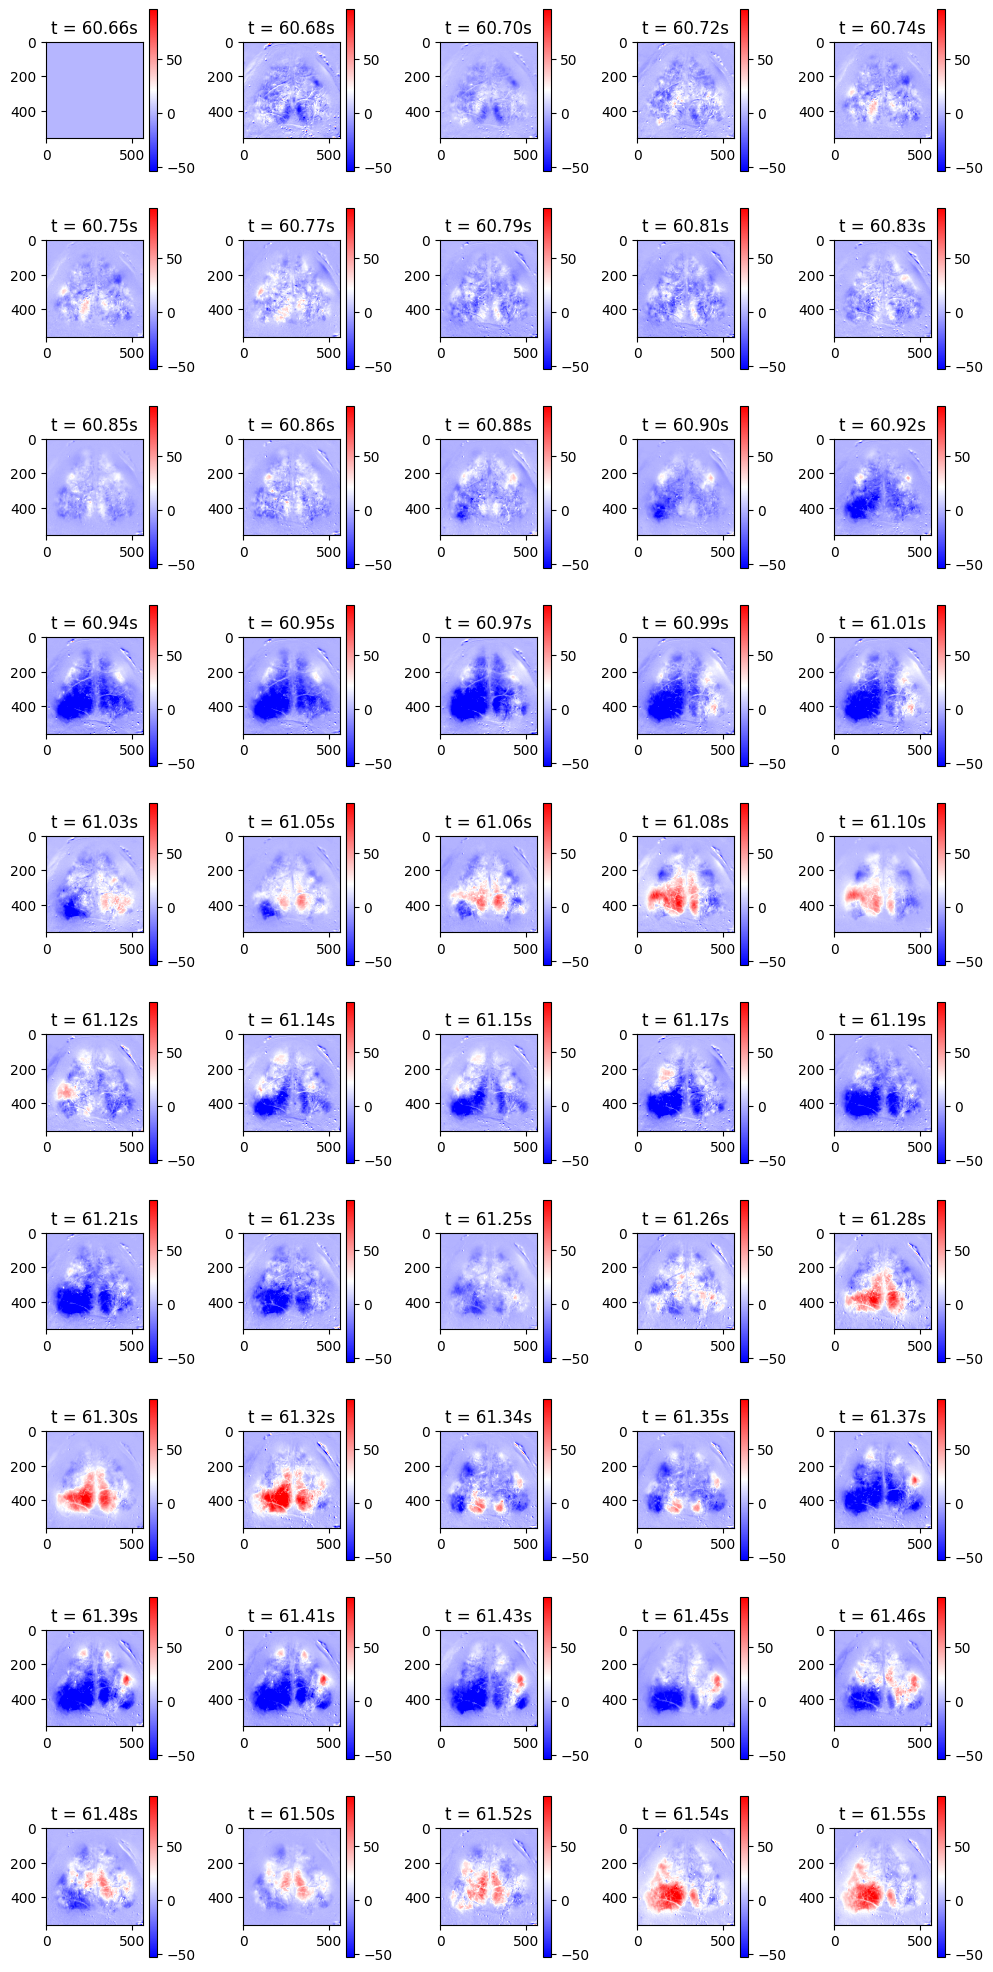

In [3]:
data717.oneTrial(-.2,.7,100,0)

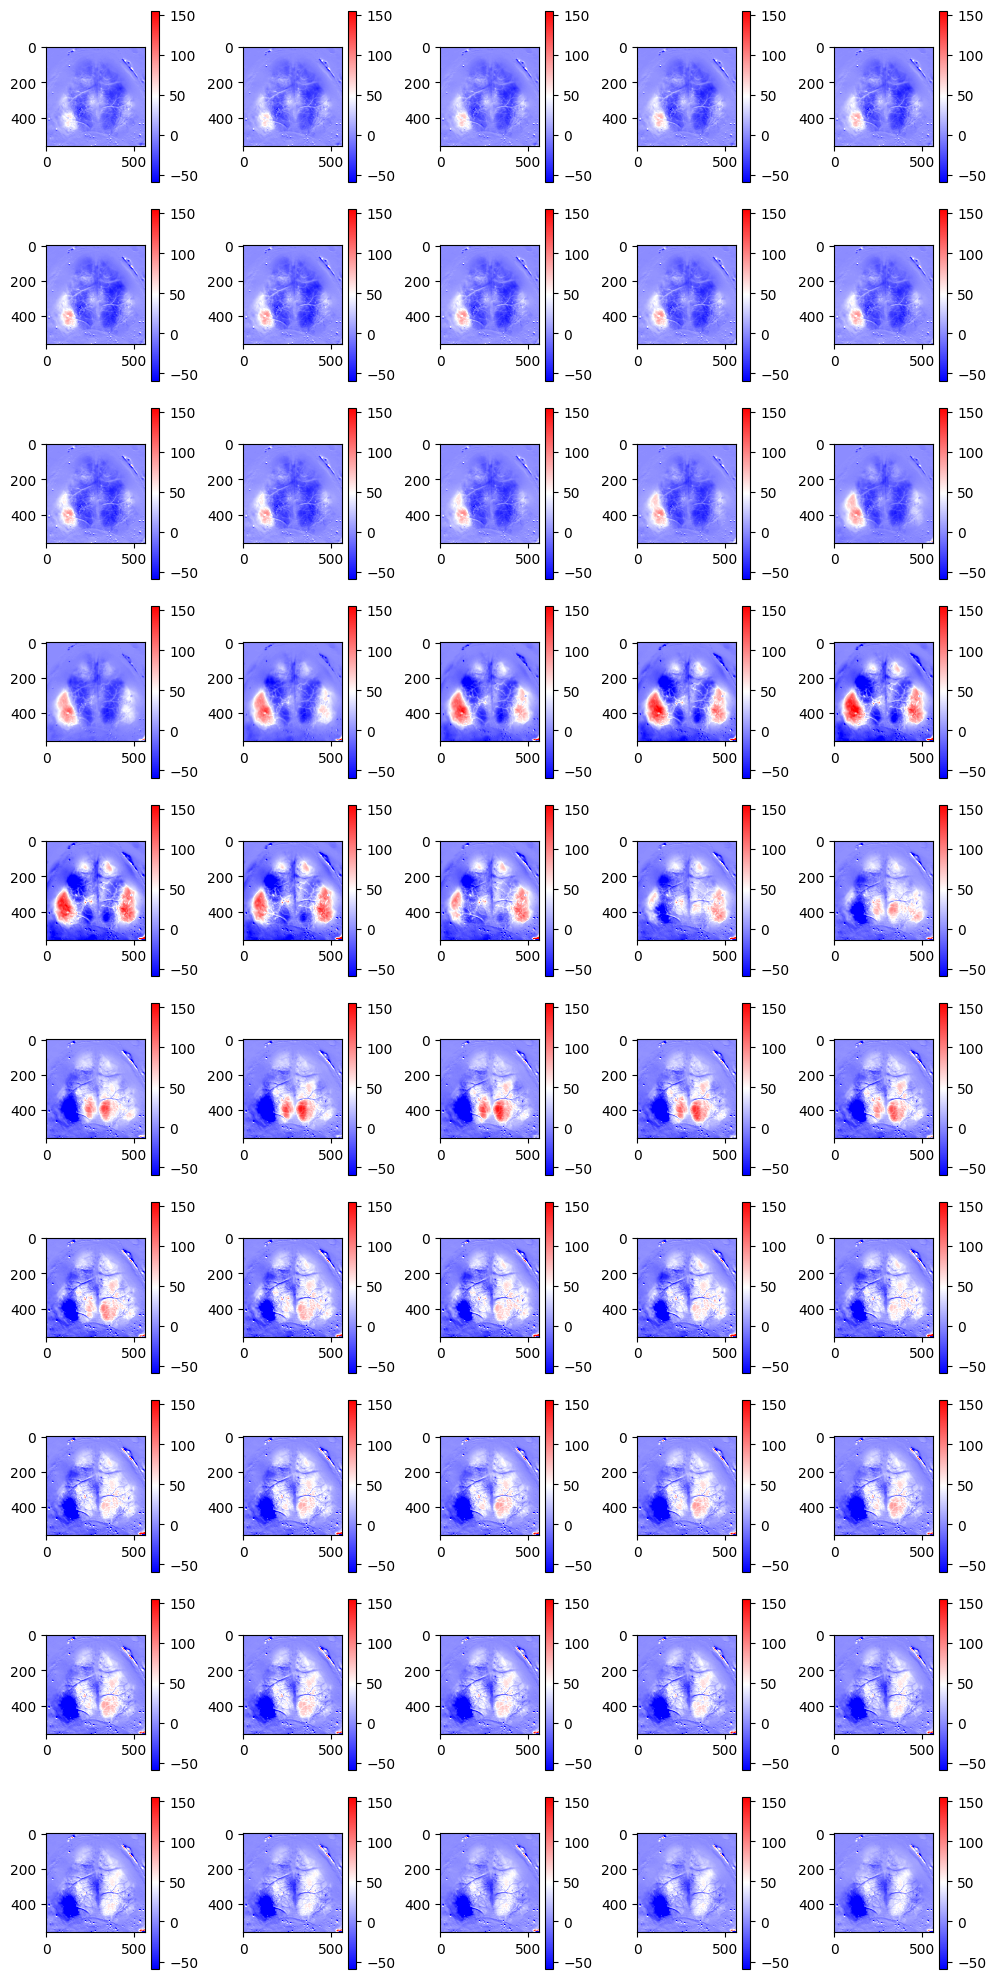

In [4]:
data717.allTrials(-.2,.7,100)

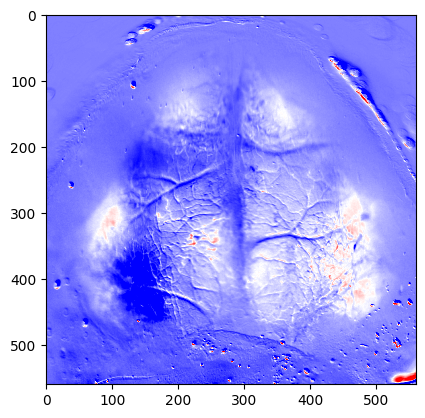

In [5]:
data717.fullAvg(-.2,.7,100)

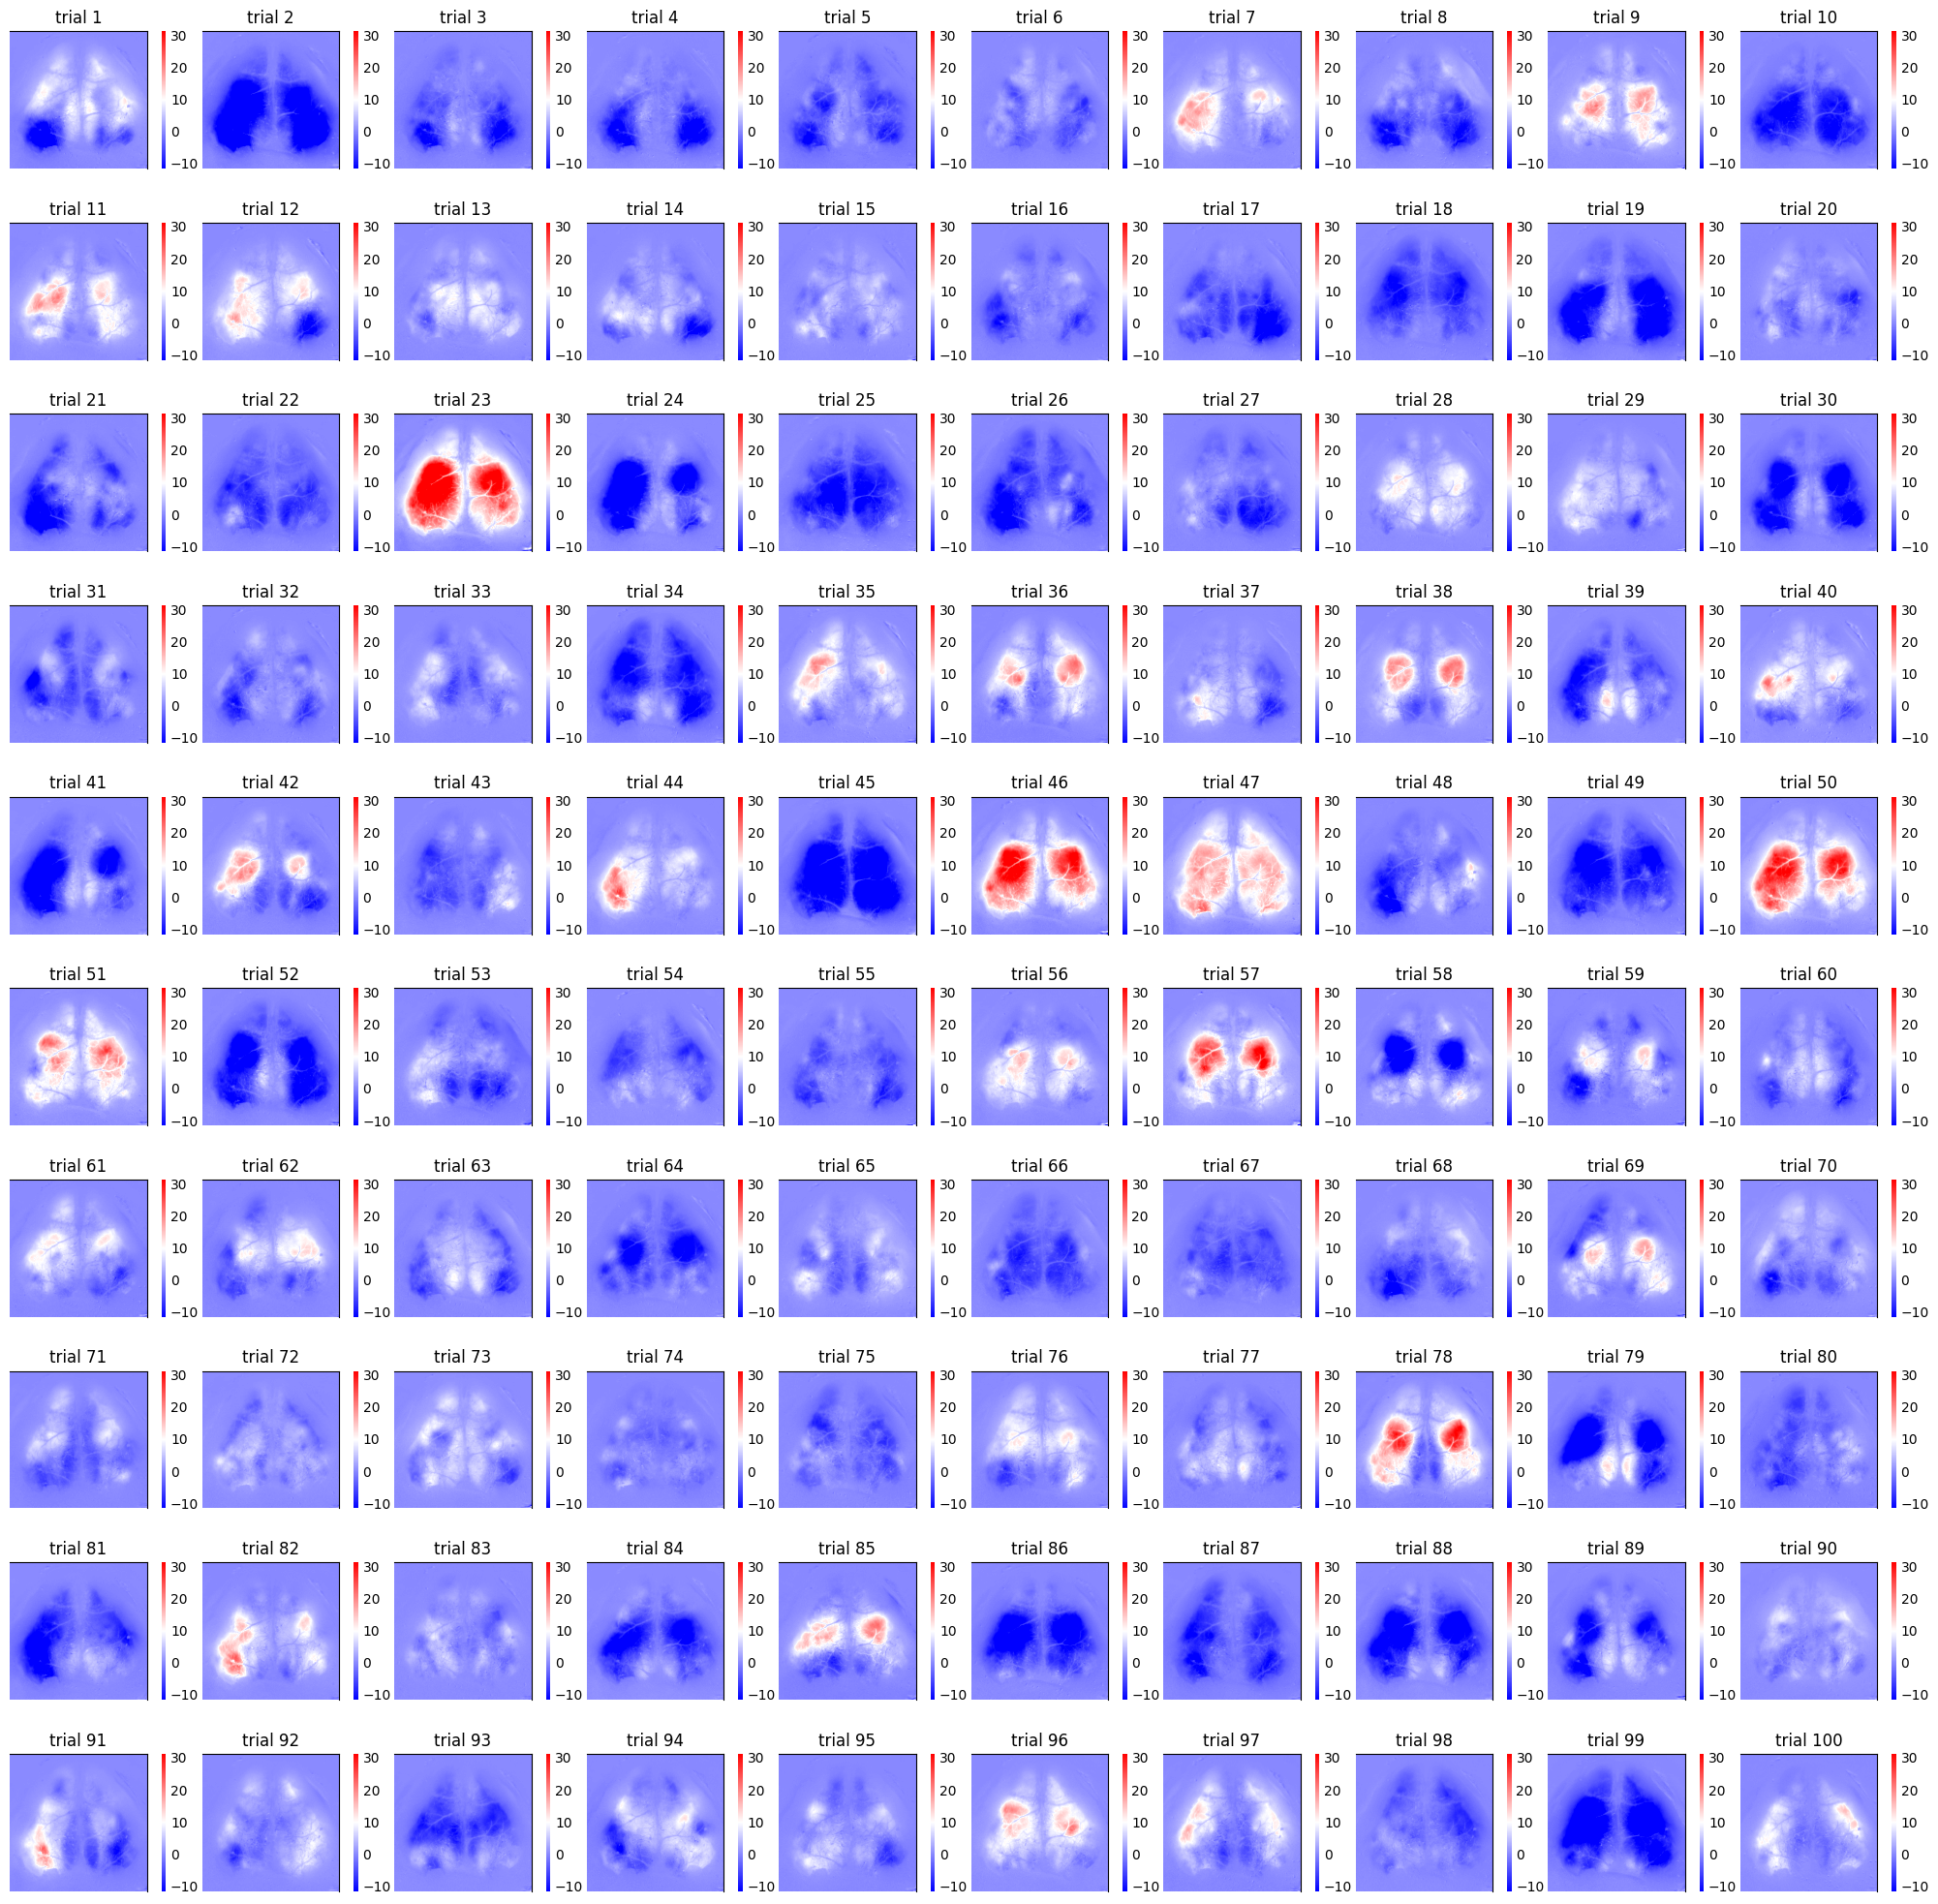

In [6]:
data717.compareAvgs()

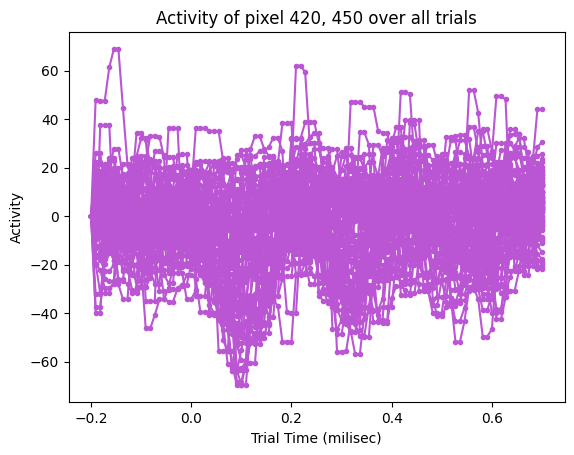

In [9]:
data717.trackPixel(x=400,y=400,trialCountStart=0,trialCountStop=75)

In [ ]:
data717.standardError(x=400,y=400)

In [ ]:
print(np.unique(data717.pulseLengths))
print(np.unique(data717.galvoX))
print(np.unique(data717.galvoY))